In [1]:
import os
import warnings
from pathlib import Path

import torch
import torch.nn as nn
import torchmetrics
from config import get_config, get_weights_file_path
from dataset import BilingualDataset, casual_mask
# Huggingface datasets and tokenizers 
from datasets import load_dataset
from model import build_transformer
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device): 
    
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')
    
    # Precompute the encoder output and reuse it for every step 
    encoder_output = model.encode(source, source_mask) 
    
    # Initialize the decoder input with the sos token 
    decoder_input = torch.empty(1, 1).fill_(sos_idx).type_as(source).to(device) 
    
    while True: 
        if decoder_input.size(1) == max_len:  
            break 
        
        # build mask for target 
        decoder_mask = casual_mask(decoder_input.size(1)).type_as(source_mask).to(device) 
        
        # calculate output 
        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask) 

        # get next token 
        prob = model.project(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat(
            [decoder_input, torch.empty(1, 1).type_as(source).fill_(next_word.item()).to(device)
            ], dim = 1
        )
        
        if next_word == eos_idx: 
            break 
        
    return decoder_input.squeeze(0)


def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, 
                   device, print_msg, global_step, writer, num_examples=2):
    model.eval() 
    count = 0 
    source_texts = [] 
    expected = [] 
    predicted = [] 
    
    try: 
        # get the console window width 
        with os.popen('stty size', 'r') as console: 
            _, console_width = console.read().split() 
            console_width = int(console_width) 
    except: 
        # If we can't get the console width, use 80 as default 
        console_width = 80 
        
    with torch.no_grad(): 
        for batch in validation_ds: 
            count += 1 
            encoder_input = batch["encoder_input"].to(device) # (b, seq_len)
            encoder_mask = batch["encoder_mask"].to(device) # (b, 1, 1, seq_len) 

            # check that the batch size is 1 
            assert encoder_input.size(0) == 1, "Batch  size must be 1 for val"
            
            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)
            
            source_text = batch["src_text"][0]
            target_text = batch["tgt_text"][0] 
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy()) 
            
            source_texts.append(source_text) 
            expected.append(target_text) 
            predicted.append(model_out_text) 
            
            # Print the source, target and model output 
            print_msg('-'*console_width) 
            print_msg(f"{f'SOURCE: ':>12}{source_text}") 
            print_msg(f"{f'TARGET: ':>12}{target_text}")
            print_msg(f"{f'PREDICTED: ':>12}{model_out_text}") 
                      
            if count == num_examples: 
                print_msg('-'*console_width)
                break 
            
    if writer: 
        
        # Evaluate the character error rate 
        # Compute the char error rate 
        metric = torchmetrics.CharErrorRate() 
        cer = metric(predicted, expected) 
        writer.add_scalar('validation cer', cer, global_step) 
        writer.flush() 
        
        # Compute the word error rate 
        metric = torchmetrics.WordErrorRate() 
        wer = metric(predicted, expected) 
        writer.add_scalar('validation wer', wer, global_step) 
        writer.flush() 
        
        # Compute the BLEU metric 
        metric = torchmetrics.BLEUScore() 
        bleu = metric(predicted, expected) 
        writer.add_scalar('validation BLEU', bleu, global_step) 
        writer.flush() 
        
def get_all_sentences(ds, lang): 
    for item in ds: 
        yield item['translation'][lang]
        
def get_or_build_tokenizer(config, ds, lang): 
    tokenizer_path = Path(config['tokenizer_file'].format(lang)) 
    if not Path.exists(tokenizer_path): 
        # Most code taken from: https://huggingface.co/docs/tokenizers/quicktour 
        tokenizer = Tokenizer(WordLevel(unk_token="[UNK]")) 
        tokenizer.pre_tokenizer = Whitespace() 
        trainer = WordLevelTrainer(special_tokens = ["[UNK]", "[PAD]", "[SOS]", "[EOS]"], min_frequency=2)
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer=trainer)
        tokenizer.save(str(tokenizer_path)) 
    else: 
        tokenizer = Tokenizer.from_file(str(tokenizer_path)) 
    return tokenizer 

def get_ds(config): 
    # It only has the train split, so we divide it overselves 
    ds_raw = load_dataset('opus_books', f"{config['lang_src']}-{config['lang_tgt']}", split='train')
    
    # Build tokenizers 
    tokenizer_src = get_or_build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = get_or_build_tokenizer(config, ds_raw, config['lang_tgt']) 
    
    # Keep 90% for training, 10% for validation 
    train_ds_size = int(0.9* len(ds_raw))
    val_ds_size = len(ds_raw) - train_ds_size
    train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size])
    # sort the datasets by length
    sorted_train_ds = sorted(train_ds_raw, key=lambda x: len(tokenizer_src.encode(x['translation'][config['lang_src']]).ids))
    filtered_sorted_train_ds = [item for item in sorted_train_ds if len(tokenizer_src.encode(item['translation'][config['lang_src']]).ids) < 150]
    filtered_sorted_train_ds = [item for item in filtered_sorted_train_ds if len(tokenizer_src.encode(item['translation'][config['lang_src']]).ids) > 2]
    filtered_sorted_train_ds = [item for item in filtered_sorted_train_ds if len(tokenizer_src.encode(item['translation'][config['lang_src']]).ids)+10 > len(tokenizer_tgt.encode(item['translation'][config['lang_tgt']]).ids)]
    train_ds = BilingualDataset(filtered_sorted_train_ds, tokenizer_src, tokenizer_tgt, config['lang_src'], 
                                config['lang_tgt'], config['seq_len'])
    val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], 
                                config['lang_tgt'], config['seq_len'])
    
    # Find the maximum length of each sentence in the source and target sentence 
    max_len_src = 0 
    max_len_tgt = 0 
    
    for item in ds_raw: 
        src_ids = tokenizer_src.encode(item['translation'][config['lang_src']]).ids
        tgt_ids = tokenizer_src.encode(item['translation'][config['lang_tgt']]).ids
        max_len_src = max(max_len_src, len(src_ids))
        max_len_tgt = max(max_len_tgt, len(tgt_ids))
        
    print(f'Max length of source sentence: {max_len_src}') 
    print(f'Max length of target sentence: {max_len_tgt}') 
    
    train_dataloader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True, collate_fn=collate_fn)
    val_dataloader = DataLoader(val_ds, batch_size=1, shuffle=True) 
    
    return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt 

def collate_fn(batch):
    #print('----------------------------------------------')
    encoder_input_max = max(x["encoder_str_length"] for x in batch)
    decoder_input_max = max(x["decoder_str_length"] for x in batch)

    encoder_inputs = []
    decoder_inputs = []
    encoder_mask = []
    decoder_mask = []
    label = []
    src_text = []
    tgt_text = []

    for b in batch:
        encoder_inputs.append(b["encoder_input"][:encoder_input_max])
        decoder_inputs.append(b["decoder_input"][:decoder_input_max])
        encoder_mask.append((b["encoder_mask"][0, 0, :encoder_input_max]).unsqueeze(0).unsqueeze(0).unsqueeze(0).int())
        decoder_mask.append((b["decoder_mask"][0, :decoder_input_max, :decoder_input_max]).unsqueeze(0).unsqueeze(0))
        label.append(b["label"][:decoder_input_max])
        src_text.append(b["src_text"])
        tgt_text.append(b["tgt_text"])
    return {
        "encoder_input":torch.vstack(encoder_inputs),
        "decoder_input":torch.vstack(decoder_inputs),
        "encoder_mask": torch.vstack(encoder_mask),
        "decoder_mask": torch.vstack(decoder_mask),
        "label":torch.vstack(label),
        "src_text":src_text,
        "tgt_text":tgt_text
    }

def get_model(config, vocab_src_len, vocab_tgt_len): 
    model = build_transformer(vocab_src_len, vocab_tgt_len, config["seq_len"], 
                              config["seq_len"], d_model=config["d_model"])
    return model 

In [2]:
warnings.filterwarnings("ignore") 
config = get_config()     # Define the device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print("Using device:", device) 
# Make sure the weights folder exists 
Path(config['model_folder']).mkdir(parents=True, exist_ok=True) 

train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config) 
model = get_model(config, tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)

# Tensorboard 
writer = SummaryWriter(config['experiment_name']) 

optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps=1e-9) 

MAX_LR = 10**-3
STEPS_PER_EPOCH = len(train_dataloader)
EPOCHS = 90

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=MAX_LR, 
                                                steps_per_epoch=STEPS_PER_EPOCH, 
                                                epochs=EPOCHS,
                                                pct_start=0.1,
                                                div_factor=10,
                                                three_phase=True,
                                                final_div_factor=10,
                                                anneal_strategy='linear')

Using device: cuda
Max length of source sentence: 471
Max length of target sentence: 482


In [3]:

# If the user specified a model to preload before training, load it 
initial_epoch = 0 
global_step = 0 
if config['preload']: 
    model_filename = get_weights_file_path(config, config['preload']) 
    print(f'Preloading model {model_filename}') 
    state = torch.load(model_filename) 
    model.load_state_dict(state['model_state_dict'])
    global_step = state['global_step']
    print("Preloaded")
    
loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_src.token_to_id('[PAD]'), label_smoothing=0.1)

In [4]:
scaler = torch.cuda.amp.GradScaler()
lr = [0.0]
for epoch in range(initial_epoch, EPOCHS): 
    loss_acc = []
    torch.cuda.empty_cache() 
    model.train() 
    batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
    for batch in batch_iterator: 
        optimizer.zero_grad(set_to_none=True) 
        encoder_input = batch['encoder_input'].to(device) # (B, seq_len)
        decoder_input = batch['decoder_input'].to(device) # (B, seq_len) 
        encoder_mask = batch['encoder_mask'].to(device) # (B, 1, 1, seq_len) 
        decoder_mask = batch['decoder_mask'].to(device) # (B, 1, seq_len,-seq_len) 
        
        # Run the tensors through the encoder, decoder and the projection layer 
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            encoder_output = model.encode(encoder_input, encoder_mask) # (B, seq_len, d_model) 
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask) 
            proj_output = model.project(decoder_output) # (B, seq_len, vocab_size) 
        
            # Compare the output with the label 
            label = batch['label'].to(device) # (B, seg_len)
            
            # Compute the loss using a simple cross entropy 
            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1)) 
            loss_acc.append(loss)
        batch_iterator.set_postfix({"loss_acc": f"{torch.mean(torch.stack(loss_acc)).item():6.3f}", 
                                    "loss": f"{loss.item():6.3f}",
                                    "Sqn_L":f"{batch['encoder_input'].shape[1]}"}) 
        
        # Log the loss 
        writer.add_scalar('train loss', torch.mean(torch.stack(loss_acc)).item(), global_step) 
        writer.flush() 
        
        # Backpropagate the loss 
        scaler.scale(loss).backward()
        scale = scaler.get_scale()
        scaler.step(optimizer)
        scaler.update()
        skip_lr_sched = (scale > scaler.get_scale())
        if not skip_lr_sched:
            scheduler.step()
        lr.append(scheduler.get_last_lr())
        
        
        global_step += 1 
        
    # Run validation at the end of every epoch
    run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, 
                    lambda msg: batch_iterator.write(msg), global_step, writer)
    
    # Save the model at the end of every epoch 
    model_filename = get_weights_file_path(config, f"{epoch:02d}") 
    torch.save({ 
                'epoch': epoch, 
                'model_state_dict': model.state_dict(), 
                'optimizer_state_dict': optimizer.state_dict(), 
                'global_step': global_step}
                , model_filename) 


Processing Epoch 00:   0%|          | 0/1667 [00:00<?, ?it/s]

Processing Epoch 00: 100%|██████████| 1667/1667 [05:07<00:00,  5.42it/s, loss_acc=5.872, loss=5.143, Sqn_L=44] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: "Did what?" exclaimed George and I.
    TARGET: – Fait quoi ? m’exclamai-je de concert avec George.
 PREDICTED: -- Comment ? dit le marin et je suis bien .
--------------------------------------------------------------------------------
    SOURCE: Would not his presence disturb the little colony till then so united?
    TARGET: Sa présence n'apporterait-elle pas quelque trouble dans la petite colonie, si unie jusqu'alors?
 PREDICTED: La femme ne pouvait pas le plus de la nuit ?
--------------------------------------------------------------------------------


Processing Epoch 01: 100%|██████████| 1667/1667 [05:07<00:00,  5.42it/s, loss_acc=4.505, loss=3.736, Sqn_L=82] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: "'Tis well," struck in an old woman.
    TARGET: – C’est bon, reprenait une vieille.
 PREDICTED: – C ’ est bien , reprit un vieux , une vieille femme .
--------------------------------------------------------------------------------
    SOURCE: He returned towards the marble table, and saw that the representation had been interrupted.
    TARGET: Il se retourna vers la table de marbre, et vit que la représentation était interrompue.
 PREDICTED: Il revint vers la table de marbre , et vit que le était devenu .
--------------------------------------------------------------------------------


Processing Epoch 02: 100%|██████████| 1667/1667 [05:04<00:00,  5.47it/s, loss_acc=3.831, loss=3.629, Sqn_L=48] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Clélia pouvait à peine se soutenir, elle chercha partout son oncle, le bon abbé don Cesare, et enfin le trouva à la chapelle, où il priait avec ferveur ; il avait la figure renversée.
    TARGET: Clelia could hardly keep on her feet; she sought everywhere for her uncle, the good Don Cesare, and at length found him in the chapel, where he was praying fervently: from his face he appeared upset.
 PREDICTED: Clelia might be already to be , she was his uncle , the good Priore Cesare , and finally the chapel , at the chapel , when he was the face of ; he had the face of .
--------------------------------------------------------------------------------
    SOURCE: But Camille insisted on these Sunday outings, which gave him the satisfaction of showing off his wife. When he met a colleague, particularly one of his chiefs, he felt quite proud to exchange bows with him, in the company of Madame.
    TARG

Processing Epoch 03: 100%|██████████| 1667/1667 [05:04<00:00,  5.47it/s, loss_acc=3.467, loss=3.670, Sqn_L=75] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: At that moment, the young clerk who was serving mass rang the bell for the Elevation.
    TARGET: En ce moment, le jeune clerc qui servait la messe sonna pour l’élévation.
 PREDICTED: En ce moment , le jeune clerc qui faisait la masse de la cloche du .
--------------------------------------------------------------------------------
    SOURCE: « — Nous allons avoir de la lumiere, dis-je on faisant craquer une allumette et en enflammant une bougie de cire que j’avais eu soin d’apporter avec moi.
    TARGET: "'We'll soon have a light,' I said, striking a match and putting it to a wax candle which I had brought with me.
 PREDICTED: " We have just been the very ," I said , a and a candle - , and a candle - which I had had had had been with me .
--------------------------------------------------------------------------------


Processing Epoch 04: 100%|██████████| 1667/1667 [05:04<00:00,  5.47it/s, loss_acc=3.244, loss=3.282, Sqn_L=77] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: At any rate, she cannot grow many degrees worse, without authorising us to lock her up for the rest of her life."
    TARGET: Espérons plutôt que ce séjour la persuadera de son insignifiance.
 PREDICTED: Au moins , elle ne peut pas se faire de plus en plus mal , sans nous a l ’ écluse de sa vie .
--------------------------------------------------------------------------------
    SOURCE: I heard a sound of tambourine and music.
    TARGET: J’entends un bruit de tambour et de musique.
 PREDICTED: J ’ entendis un bruit de musique et de musique .
--------------------------------------------------------------------------------


Processing Epoch 05: 100%|██████████| 1667/1667 [05:05<00:00,  5.46it/s, loss_acc=3.084, loss=3.116, Sqn_L=98] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: "If you get angry it will never go.
    TARGET: Si tu te fâches, jamais ça ne marchera.
 PREDICTED: -- Si vous vous en , vous ne vous en irez pas .
--------------------------------------------------------------------------------
    SOURCE: What strange craving impelled him on a sudden to tell this tavern-wenchabout Jean's legacy?
    TARGET: Quel étrange besoin le poussa tout à coup à raconter à cette servante debrasserie l'héritage de Jean?
 PREDICTED: Que d ' étranges desseins le poussait soudain à l ' héritage de cette - Jean ?
--------------------------------------------------------------------------------


Processing Epoch 06: 100%|██████████| 1667/1667 [05:13<00:00,  5.31it/s, loss_acc=2.958, loss=2.997, Sqn_L=102]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: So we had to save it."
    TARGET: Donc il fallait la conserver.
 PREDICTED: Nous avions donc à la sauver .
--------------------------------------------------------------------------------
    SOURCE: Quelques larmes fort rares coulaient de temps à autre sur ses joues insensibles ; ses femmes comprirent par un signe qu’elle voulait être mise au lit.
    TARGET: A few rare tears trickled from time to time down her insentient cheeks; her women gathered from a sign which she made that she wished to be put to bed.
 PREDICTED: A few tears very few little from time , almost ; his women were by a sign which she was anxious to be attached to the bed .
--------------------------------------------------------------------------------


Processing Epoch 07: 100%|██████████| 1667/1667 [05:06<00:00,  5.44it/s, loss_acc=2.851, loss=2.900, Sqn_L=77] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: She accepted his invitation; they danced.
    TARGET: Elle accepta son invitation ; ils dansèrent.
 PREDICTED: Elle acceptait son invitation ; elles dansé .
--------------------------------------------------------------------------------
    SOURCE: For an hour we went along it in this fashion, staying only a few meters away.
    TARGET: Nous la suivîmes ainsi pendant une heure, à quelques mètres de distance seulement.
 PREDICTED: Pendant une heure , nous nous nous mîmes en route , nous nous nous mîmes en route , à ne pas rester que quelques mètres .
--------------------------------------------------------------------------------


Processing Epoch 08: 100%|██████████| 1667/1667 [05:04<00:00,  5.47it/s, loss_acc=2.755, loss=3.232, Sqn_L=62] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Everything showed the neighbourhood of a river.
    TARGET: Tout faisait pressentir l’approche d’une rivière.
 PREDICTED: Tout y dénotait les environs d ’ un fleuve .
--------------------------------------------------------------------------------
    SOURCE: "But your father will not stop there."
    TARGET: --Mais ton père ne s'en tiendra pas là?
 PREDICTED: -- Mais votre père ne s ' y arrête pas .
--------------------------------------------------------------------------------


Processing Epoch 09: 100%|██████████| 1667/1667 [05:05<00:00,  5.45it/s, loss_acc=2.635, loss=2.794, Sqn_L=44] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: CHAPTER XXXIV
    TARGET: CHAPITRE XXXIV
 PREDICTED: XXXIV
--------------------------------------------------------------------------------
    SOURCE: "Why did he wish it?
    TARGET: «Pourquoi le désirait-il?
 PREDICTED: -- Pourquoi le regrettait - il ?
--------------------------------------------------------------------------------


Processing Epoch 10: 100%|██████████| 1667/1667 [05:07<00:00,  5.43it/s, loss_acc=2.467, loss=2.456, Sqn_L=57] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: That gentleman was really ruined, and that at the moment when he was about to attain his end.
    TARGET: Quant à ce gentleman, il était bien et dûment ruiné, et cela au moment où il allait atteindre son but.
 PREDICTED: Ce gentilhomme était réellement ruiné et cela , au moment où il allait arriver à son but .
--------------------------------------------------------------------------------
    SOURCE: Captain Nemo was already there.
    TARGET: Le capitaine Nemo m'y avait précédé.
 PREDICTED: Le capitaine Nemo était déjà là .
--------------------------------------------------------------------------------


Processing Epoch 11: 100%|██████████| 1667/1667 [05:05<00:00,  5.45it/s, loss_acc=2.321, loss=2.328, Sqn_L=47] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Greece crowned her mountains with a temple harmonious to the eye; India disembowelled hers, to chisel therein those monstrous subterranean pagodas, borne up by gigantic rows of granite elephants.
    TARGET: Selon que le symbole à exprimer était gracieux ou sombre, la Grèce couronnait ses montagnes d’un temple harmonieux à l’œil, l’Inde éventrait les siennes pour y ciseler ces difformes pagodes souterraines portées par de gigantesques rangées d’éléphants de granit.
 PREDICTED: La Grèce , avec un temple , délicatement dessiné ses yeux , les Indes , sous - ces gigantesques pagodes , supporté par des rangées de granit .
--------------------------------------------------------------------------------
    SOURCE: It was much worse a quarter of an hour later; they could hear in the distance a few snatches of a popular and, it must be admitted, not too refined song which one of the inmates was singing

Processing Epoch 12: 100%|██████████| 1667/1667 [05:04<00:00,  5.48it/s, loss_acc=2.192, loss=2.196, Sqn_L=58] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: "That is sufficient, my Lord!
    TARGET: -- Il suffit, Milord, j'ai juré.
 PREDICTED: -- Cela suffit , Milord !
--------------------------------------------------------------------------------
    SOURCE: So they were now having a little rest at home, and both lookedforward to settling in Havre if they could find a satisfactory opening.
    TARGET: Tous les deux prenaient donc un peu de repos dans leur famille, et tousles deux formaient le projet de s'établir au Havre s'ils parvenaient àle faire dans des conditions satisfaisantes.
 PREDICTED: Ils étaient maintenant à la maison un peu , et ils s ' à s ' installer dans le Havre , si elles eussent découvert une ouverture heureuse .
--------------------------------------------------------------------------------


Processing Epoch 13: 100%|██████████| 1667/1667 [05:03<00:00,  5.49it/s, loss_acc=2.079, loss=2.154, Sqn_L=110]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: D’Artagnan went out, but at the door his heart almost failed him, and he felt inclined to return.
    TARGET: D'Artagnan sortit; mais à la porte le coeur fut prêt à lui manquer, et peu s'en fallut qu'il ne rentrât.
 PREDICTED: D ' Artagnan sortit , mais à la porte , son coeur lui manqua presque de le paraître , et il se sentit forcé de revenir .
--------------------------------------------------------------------------------
    SOURCE: He said, “Yes”; and I bade him give it to the poor Spaniard, who was in as much want of it as his father; and I sent one of the cakes that Friday brought to the Spaniard too, who was indeed very weak, and was reposing himself upon a green place under the shade of a tree; and whose limbs were also very stiff, and very much swelled with the rude bandage he had been tied with.
    TARGET: Je lui envoyai aussi un des gâteaux que Vendredi avait été chercher. Cet homm

Processing Epoch 14: 100%|██████████| 1667/1667 [05:04<00:00,  5.47it/s, loss_acc=1.979, loss=1.993, Sqn_L=97] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: "Your list of the common extent of accomplishments," said Darcy, "has too much truth.
    TARGET: – Ce n’est que trop vrai, dit Darcy.
 PREDICTED: – Votre liste de l ’ ensemble commun , dit Darcy , est votre vérité .
--------------------------------------------------------------------------------
    SOURCE: This nuisance, which affected everybody alike, placed M. de Renal under the fortunate obligation to immortalise his administration by a wall twenty feet in height and seventy or eighty yards long.
    TARGET: Cet inconvénient, senti par tous, mit M. de Rênal dans l’heureuse nécessité d’immortaliser son administration par un mur de vingt pieds de hauteur et de trente ou quarante toises de long.
 PREDICTED: Cet ennuyeux , qui fit comme chacun , mit M . de Rênal dans la obligés de punir de l ’ administration par une vingtaine de pieds de hauteur et de soixante - quinze mètres .
---------------

Processing Epoch 15: 100%|██████████| 1667/1667 [05:05<00:00,  5.45it/s, loss_acc=1.893, loss=1.937, Sqn_L=42] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: "She will receive you better by and bye."
    TARGET: --Elle va mieux vous recevoir.
 PREDICTED: -- Elle vous recevra de mieux et de vous .
--------------------------------------------------------------------------------
    SOURCE: We should have been in a fine fix!"
    TARGET: Nous serions propres!
 PREDICTED: Nous aurions été en beau point .
--------------------------------------------------------------------------------


Processing Epoch 16: 100%|██████████| 1667/1667 [05:07<00:00,  5.43it/s, loss_acc=1.820, loss=1.837, Sqn_L=89] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: It was, therefore, decided that the expedition should be carried through the Far West, so as to include all that region situated on the right of the Mercy.
    TARGET: Il fut donc décidé que l'expédition se porterait à travers le Far- West, de manière à englober toute la partie située sur la droite de la Mercy.
 PREDICTED: Il fut donc décidé que l ' expédition devait être transporté dans le Far - West , et , à toute cette région située sur la droite de la Mercy .
--------------------------------------------------------------------------------
    SOURCE: I obeyed: joy made me agile: I sprang up before him. A hearty kissing I got for a welcome, and some boastful triumph, which I swallowed as well as I could.
    TARGET: J'obéis, la joie me rendit agile; je sautai devant lui; je reçus un baiser, et je supportai mon triomphe le mieux possible.
 PREDICTED: Je m ' écriai : « Une joie me fit un profo

Processing Epoch 17: 100%|██████████| 1667/1667 [05:05<00:00,  5.46it/s, loss_acc=1.760, loss=1.792, Sqn_L=76] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: 'Where are you going, my lad!' replied the other, not recognising him.
    TARGET: – Où vas-tu, mon garçon ? répondit l’autre qui ne le reconnaissait plus.
 PREDICTED: – Où allez - vous , mon garçon , lui répondit l ’ autre en ne le reconnaissant pas .
--------------------------------------------------------------------------------
    SOURCE: He knelt on the ground before her, and with both elbows on her knees looked at her with a smile, his face upturned.
    TARGET: Il se mettait par terre, devant elle; et, les deux coudes sur ses genoux, il la considérait avec un sourire, et le front tendu.
 PREDICTED: Il s ' agenouilla devant elle et , les deux coudes sur les genoux , il regarda ses deux yeux , avec un sourire et appuyé sur sa face .
--------------------------------------------------------------------------------


Processing Epoch 18: 100%|██████████| 1667/1667 [05:05<00:00,  5.46it/s, loss_acc=1.721, loss=1.743, Sqn_L=72] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: "That concerns your Majesty more than me," said the cardinal.
    TARGET: -- Cela regarde Votre Majesté plus que moi, dit le cardinal.
 PREDICTED: -- Cela regarde plus que moi Votre Majesté , dit le cardinal .
--------------------------------------------------------------------------------
    SOURCE: "Write to Diana and Mary to-morrow," I said, "and tell them to come home directly.
    TARGET: «Vous écrirez demain à Marie et à Diana, dis-je, et vous les prierez de venir tout de suite ici.
 PREDICTED: « Écrivez - moi demain , dis - je , Marie à l ' instant même , et dites - les de rentrer directement chez moi .
--------------------------------------------------------------------------------


Processing Epoch 19: 100%|██████████| 1667/1667 [05:05<00:00,  5.45it/s, loss_acc=1.707, loss=1.834, Sqn_L=35] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Would you believe that I sometimes spend two hours of the morning over it?
    TARGET: Croiriez-vous que je reste quelquefois jusqu'à deux heures du matin dessus!
 PREDICTED: Croyez - vous que je passe quelquefois deux heures du matin ?
--------------------------------------------------------------------------------
    SOURCE: Then he plunged down beneath the tortuous vault of the spiral staircase, and once more descended.
    TARGET: Alors il se replongea sous la voûte tortueuse de l’escalier en spirale, et redescendit.
 PREDICTED: Puis il s ’ enfonça sous la voûte osseuse de l ’ escalier , et il s ’ en descendit encore .
--------------------------------------------------------------------------------


Processing Epoch 20: 100%|██████████| 1667/1667 [05:05<00:00,  5.46it/s, loss_acc=1.693, loss=1.729, Sqn_L=39] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: 'Besides, life is pleasant to me; this is a quiet spot to stay in; I have no worries,' he added, laughing, and set to work to make a list of the books which he wished to have sent to him from Paris.
    TARGET: D’ailleurs, la vie m’est agréable ; ce séjour est tranquille ; je n’y ai point d’ennuyeux, ajouta-t-il en riant, et il se mit à faire la note des livres qu’il voulait faire venir de Paris.
 PREDICTED: D ’ ailleurs la vie m ’ est bien agréable : c ’ est un lieu tranquille que je ne laisse pas d ’ humeur , ajouta - t - il en riant et se mettre au travail pour faire de la liste des livres qu ’ il voulait lui envoyer de Paris .
--------------------------------------------------------------------------------
    SOURCE: They had plenty of felt clothing, and the musmons, very numerous by this time, had furnished an abundance of wool necessary for the manufacture of this warm material.
    TARG

Processing Epoch 21: 100%|██████████| 1667/1667 [05:04<00:00,  5.48it/s, loss_acc=1.683, loss=1.695, Sqn_L=124]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: And it may have been a ringing in my ear, from this organ filling with impeded blood, but it seemed to me that Conseil's shout had received an answer back.
    TARGET: Et, fût-ce un de ces bourdonnements dont le sang oppressé emplit l'oreille, mais il me sembla qu'un cri répondait au cri de Conseil.
 PREDICTED: Et c ' est peut - être que j ' entendis la voix de cet orgue se remplir avec son sang , mais il me semblait que l ' appel de Conseil avait reçu une réponse à mon oreille .
--------------------------------------------------------------------------------
    SOURCE: Dès aujourd’hui, si la femme de l’homme de génie daignait faire une démarche, si peu significative qu’elle fût, on rappellerait le comte avec transport ; mais il rentrera par une bien plus belle porte, s’il veut attendre que le fruit soit mûr.
    TARGET: At this very moment, if the wife of the man of talent deigned to make an 

Processing Epoch 22: 100%|██████████| 1667/1667 [05:04<00:00,  5.47it/s, loss_acc=1.673, loss=1.739, Sqn_L=55] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Comme il l’abordait, Fabrice l’entendit qui disait :
    TARGET: As he came up to her, Fabrizio heard her say:
 PREDICTED: As he was to be saying , Fabrizio heard him say :
--------------------------------------------------------------------------------
    SOURCE: What would Conseil say?
    TARGET: Qu'allait dire Conseil ?
 PREDICTED: Que dirait Conseil ?
--------------------------------------------------------------------------------


Processing Epoch 23: 100%|██████████| 1667/1667 [05:03<00:00,  5.50it/s, loss_acc=1.664, loss=1.708, Sqn_L=86] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: He was hoisted up like a bag of flour, and fell with a brutal thud into the bottom of the carriage.
    TARGET: Il fut soulevé comme un sac de farine et lancé brutalement dans le fond de la voiture.
 PREDICTED: On le hissa comme un de farine , et il tomba avec un bruit brutal , au fond du carrosse .
--------------------------------------------------------------------------------
    SOURCE: That they might have met without ill consequence is perhaps probable; but his regard did not appear to me enough extinguished for him to see her without some danger.
    TARGET: Ses sentiments ne me semblaient pas encore assez calmés pour qu’il put risquer sans danger de la revoir. Peut-etre cette dissimulation n’était-elle pas digne de moi.
 PREDICTED: Qu ' ils m ' aient habité , c ' est peut - être probable , mais il ne me paraissait pas assez éteint pour qu ' il la vît sans danger .
----------------------

Processing Epoch 24: 100%|██████████| 1667/1667 [05:05<00:00,  5.45it/s, loss_acc=1.656, loss=1.598, Sqn_L=54] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: It was not until the night between Saturday and Sunday, after three days of discussion, that the abbe Maslon's pride gave way before the Mayor's fear, which had turned to courage.
    TARGET: Ce ne fut que dans la nuit du samedi au dimanche, après trois jours de pourparlers, que l’orgueil de l’abbé Maslon plia devant la peur du maire qui se changeait en courage.
 PREDICTED: Ce fut seulement la nuit entre samedi et le dimanche , après trois jours de discussion , que l ’ abbé Maslon a donné le cours de la crainte de M . le maire , qui s ’ était mis au courage .
--------------------------------------------------------------------------------
    SOURCE: "My boy, where are you?"
    TARGET: «Mon pauvre enfant, où es-tu?»
 PREDICTED: -- Mon enfant , où êtes - vous ?
--------------------------------------------------------------------------------


Processing Epoch 25: 100%|██████████| 1667/1667 [05:04<00:00,  5.48it/s, loss_acc=1.648, loss=1.605, Sqn_L=85] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: "This mendicant insists upon speaking to you, and pretends that you will be very glad to see him."
    TARGET: -- Ce mendiant veut à toute force vous parler, et prétend que vous serez bien aise de le voir.
 PREDICTED: -- Ce mendiant demande à vous parler , petite bouche que vous serez bien aise de le voir .
--------------------------------------------------------------------------------
    SOURCE: But the creature, waving its longwhiskers, gently retired in front of the net.
    TARGET: Mais la bête remuant ses longues moustaches reculait doucement devant lefilet.
 PREDICTED: Mais la créature , qui agitait son , s ' éloigna doucement en avant du filet .
--------------------------------------------------------------------------------


Processing Epoch 26: 100%|██████████| 1667/1667 [05:05<00:00,  5.45it/s, loss_acc=1.641, loss=1.645, Sqn_L=62] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Leaving her aunt alone behind the counter, she ran upstairs at the least pretext, and forgot herself watching Laurent paint.
    TARGET: Elle laissait sa tante seule derrière le comptoir; pour le moindre prétexte elle montait et s'oubliait à regarder peindre Laurent.
 PREDICTED: Grâce à sa tante , derrière le comptoir , elle monta l ' escalier en haut et oublia un peu Laurent .
--------------------------------------------------------------------------------
    SOURCE: After which he smoked three pipes and went to bed.
    TARGET: Après quoi, il fuma trois pipes et s’alla coucher.
 PREDICTED: Après quoi il fumait de trois pipes et s ' .
--------------------------------------------------------------------------------


Processing Epoch 27: 100%|██████████| 1667/1667 [05:06<00:00,  5.45it/s, loss_acc=1.635, loss=1.649, Sqn_L=45] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: I can only wish you better luck in Devonshire.
    TARGET: Je vous souhaite meilleure chance dans le Devonshire.
 PREDICTED: Je ne puis avoir pour vous une meilleure chance dans le Devonshire .
--------------------------------------------------------------------------------
    SOURCE: At the sight of this line of cuirassed backs, undulating as they rose through the gloom, one would have pronounced it a serpent with steel scales, which was raising itself erect in front of the church.
    TARGET: À voir s’élever en ondulant dans l’ombre cette ligne de dos cuirassés, on eût dit un serpent à écailles d’acier qui se dressait contre l’église.
 PREDICTED: À la vue de cette ligne de , à mesure qu ' ils se dressait dans les ténèbres , on eût dit un serpent d ' acier , qui se tenait debout devant l ' église .
--------------------------------------------------------------------------------


Processing Epoch 28: 100%|██████████| 1667/1667 [05:05<00:00,  5.46it/s, loss_acc=1.629, loss=1.633, Sqn_L=65] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: In short, the house in Saville Row, which must have been a very temple of disorder and unrest under the illustrious but dissipated Sheridan, was cosiness, comfort, and method idealised.
    TARGET: En somme, dans cette maison de Saville-row qui devait être le temple du désordre à l'époque de l'illustre mais dissipé Sheridan --, ameublement confortable, annonçant une belle aisance. Pas de bibliothèque, pas de livres, qui eussent été sans utilité pour Mr.
 PREDICTED: En somme , la maison de Saville - row , qui devait être bien temple de désordre et ses sous l ' illustre mais Sheridan destruction , Mrs .
--------------------------------------------------------------------------------
    SOURCE: Such an excursion could not be kept secret.
    TARGET: Une telle promenade n’aurait pu demeurer ignorée.
 PREDICTED: Une telle excursion ne pouvait se tenir secrète .
-------------------------------------

Processing Epoch 29: 100%|██████████| 1667/1667 [05:07<00:00,  5.42it/s, loss_acc=1.623, loss=1.631, Sqn_L=74] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Dreadful animals that teem in these seas and make them extremely dangerous.
    TARGET: Terribles animaux qui pullulent dans ces mers et les rendent fort dangereuses.
 PREDICTED: que les animaux dans ces mers et les rendre extrêmement dangereux .
--------------------------------------------------------------------------------
    SOURCE: This is not new.
    TARGET: Ce n’est pas nouveau.
 PREDICTED: Ce n ’ est pas nouveau .
--------------------------------------------------------------------------------


Processing Epoch 30: 100%|██████████| 1667/1667 [05:05<00:00,  5.46it/s, loss_acc=1.617, loss=1.644, Sqn_L=104]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Étienne constrained him.
    TARGET: Étienne le genait.
 PREDICTED: Étienne le força .
--------------------------------------------------------------------------------
    SOURCE: What happened when the raft was dashed upon the rocks is more than I can tell.
    TARGET: Ce qui se passa au choc du radeau contre les écueils de la côte, je ne saurais le dire.
 PREDICTED: Ce qui s ' était passé au moment où le radeau a été plus que je ne saurais le dire .
--------------------------------------------------------------------------------


Processing Epoch 31: 100%|██████████| 1667/1667 [05:05<00:00,  5.46it/s, loss_acc=1.612, loss=1.600, Sqn_L=69] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Over again."
    TARGET: Recommencez.
 PREDICTED: Plus …
--------------------------------------------------------------------------------
    SOURCE: I have a warm, unguarded temper, and I may have spoken my opinion _of_ him, and _to_ him, too freely.
    TARGET: Je suis d’une humeur assez vive et j’ai pu dire avec trop de liberté a Mr.
 PREDICTED: J ' ai bon sens , mon opinion sur lui , et sur mon derrière , je connais mon opinion .
--------------------------------------------------------------------------------


Processing Epoch 32: 100%|██████████| 1667/1667 [05:05<00:00,  5.46it/s, loss_acc=1.607, loss=1.578, Sqn_L=51] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Should Mr. Fogg choose to make him, Passepartout, a present of Kiouni, he would be very much embarrassed; and these thoughts did not cease worrying him for a long time.
    TARGET: Fogg lui en faisait cadeau, à lui, Passepartout, il en serait très embarrassé. Cela ne laissait pas de le préoccuper.
 PREDICTED: Et que devait - il signifier Phileas Fogg , Passepartout , un cadeau de Kiouni , il serait fort embarrassé , et que cette pensée ne le pas longtemps .
--------------------------------------------------------------------------------
    SOURCE: "My little mother, you are to stay, because I insist, because I wantyou.
    TARGET: --Ma petite mère, tu resteras, parce je le veux, parce que j'ai besoinde toi.
 PREDICTED: -- Ma petite mère , vous allez rester , parce que j ' ai raison , parce que je vous trouve .
--------------------------------------------------------------------------------


Processing Epoch 33: 100%|██████████| 1667/1667 [05:06<00:00,  5.44it/s, loss_acc=1.603, loss=1.621, Sqn_L=52] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: The courtyard was covered with an immense crimson awning patterned with golden stars: nothing could have been more elegant.
    TARGET: La cour d’entrée était couverte d’une immense tente de coutil cramoisi avec des étoiles en or : rien de plus élégant.
 PREDICTED: La cour était couverte d ’ une vaste tente d ’ or , et rien n ’ eût été plus élégante .
--------------------------------------------------------------------------------
    SOURCE: There was especially a number of putters and landers, even trammers of fourteen, all the youth of the pit, drinking more gin than beer.
    TARGET: Il y avait surtout la des herscheurs, des moulineurs, jusqu'a des galibots de quatorze ans, toute la jeunesse des fosses, buvant plus de genievre que de biere.
 PREDICTED: C ' était un nombre de herscheuses et de moulineurs , même des galibots de quatorze ans , toute la jeunesse de la fosse , buvant plus de gen

Processing Epoch 34: 100%|██████████| 1667/1667 [05:06<00:00,  5.43it/s, loss_acc=1.599, loss=1.576, Sqn_L=55] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Of course, as a consequence of this, we got in the way of a good many other boats, during the mile, and they in ours, and, of course, as a consequence of that, a good deal of bad language occurred.
    TARGET: En conséquence de quoi, bien entendu, nous faillîmes entrer en collision avec quantité d’autres embarcations, et elles avec nous. Et, bien entendu, cela donna lieu aux échanges courtois qui sont de mise en ces cas-la.
 PREDICTED: Nous en route , selon toute probabilité , en un de nous autres bateaux .
--------------------------------------------------------------------------------
    SOURCE: "Do you think she wants to order something of him?" said Madame Tuvache.
    TARGET: -- Viendrait-elle lui commander quelque chose? dit madame Tuvache.
 PREDICTED: -- Croyez - vous qu ’ elle lui demande de quelque chose ? dit madame Tuvache .
----------------------------------------------------------

Processing Epoch 35: 100%|██████████| 1667/1667 [05:05<00:00,  5.45it/s, loss_acc=1.594, loss=1.602, Sqn_L=56] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: The hay was all got in; the fields round Thornfield were green and shorn; the roads white and baked; the trees were in their dark prime; hedge and wood, full-leaved and deeply tinted, contrasted well with the sunny hue of the cleared meadows between.
    TARGET: On avait rentré les foins; les champs verts qui entouraient Thornfield venaient d'être fauchés; la route poudreuse était durcie par la chaleur; les arbres se montraient dans tout leur éclat: les teintes foncées des haies et des bois touffus contrastaient bien avec la nuance tendre des prairies nouvellement fauchées.
 PREDICTED: Le foin faisait verser des champs . Les champs environnants étaient encombrés de , et des chemins blanches qui étaient placées en frayeur de telles trouvait leur haie dans la même ligne , des arbres en traits épais , aux grands fauteuils un fou , contrastait vivement par les clartés de la prairie .
--------------

Processing Epoch 36: 100%|██████████| 1667/1667 [05:05<00:00,  5.46it/s, loss_acc=1.591, loss=1.602, Sqn_L=47] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Chapter 25
    TARGET: 25
 PREDICTED: CHAPITRE XXV
--------------------------------------------------------------------------------
    SOURCE: At the moment when he overtook them once more, they had changed their conversation.
    TARGET: Au moment où il les rejoignit, ils avaient changé de conversation.
 PREDICTED: Au moment où il les rejoignit une fois de plus , ils avaient changé de conversation .
--------------------------------------------------------------------------------


Processing Epoch 37: 100%|██████████| 1667/1667 [05:05<00:00,  5.45it/s, loss_acc=1.587, loss=1.629, Sqn_L=42] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: I recognized the lower slopes of some magnificent rocks carpeted by the finest zoophyte specimens, and right off, I was struck by an effect unique to this medium.
    TARGET: Je reconnus de magnifiques premiers plans de rochers, tapissés de zoophytes du plus bel échantillon, et je fus tout d'abord frappé d'un effet spécial à ce milieu.
 PREDICTED: Je reconnus les pentes inférieures de quelques rocs magnifiques et les plus beaux échantillons de zoophytes , et de droite , j ' étais frappé d ' un effet particulier à ce milieu .
--------------------------------------------------------------------------------
    SOURCE: "You came through Meung, where something befell you.
    TARGET: -- Vous êtes venu par Meung, où il vous est arrivé quelque chose, je ne sais plus trop quoi, mais enfin quelque chose.
 PREDICTED: -- Vous êtes venu à travers Meung , où quelque chose vous appartenait .
---------------

Processing Epoch 38: 100%|██████████| 1667/1667 [05:07<00:00,  5.43it/s, loss_acc=1.583, loss=1.591, Sqn_L=34] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: On the strength of it she bought a pair of yellow curtains with large stripes for her room, whose cheapness Monsieur Lheureux had commended; she dreamed of getting a carpet, and Lheureux, declaring that it wasn't "drinking the sea," politely undertook to supply her with one.
    TARGET: Aussi, elle acheta pour sa chambre une paire de rideaux jaunes à larges raies, dont M. Lheureux lui avait vanté le bon marché; elle rêva un tapis, et Lheureux, affirmant «que ce n’était pas la mer à boire», s’engagea poliment à lui en fournir un.
 PREDICTED: Il en acheta des bords jaunes à la force de ses rideaux , à pour sa chambre , dont M . Lheureux était autrefois loué ; elle rêvait à se faire un tapis , et Lheureux , déclarant qu ’ il n ’ y avait pas entre la mer , s ’ entreprit de l ’ en défaire .
--------------------------------------------------------------------------------
    SOURCE: Therefore an expl

Processing Epoch 39: 100%|██████████| 1667/1667 [05:06<00:00,  5.43it/s, loss_acc=1.579, loss=1.569, Sqn_L=37] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: "That's lucky for him--in fact, it's lucky for all of you, since you are all on the wrong side of the law in this matter.
    TARGET: – Il a de la chance ! En fait, tous vous avez de la chance, car vous avez choisi le mauvais côté de la loi en cette affaire.
 PREDICTED: -- C ' est heureux en lui : c ' est en effet à vous de toutes , puisque vous êtes de quelque part de la loi , en cette circonstance .
--------------------------------------------------------------------------------
    SOURCE: Unless you produce your nominee within five-and-twenty minutes, I claim the match."
    TARGET: Si vous ne présentez pas votre champion dans vingt- cinq minutes, je réclame l'enjeu.
 PREDICTED: À moins que vous ne votre champion dans vingt - cinq minutes , je n ' ose en réclamer l ' union .
--------------------------------------------------------------------------------


Processing Epoch 40: 100%|██████████| 1667/1667 [05:05<00:00,  5.47it/s, loss_acc=1.576, loss=1.584, Sqn_L=59] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Gudule!"
    TARGET: Gudule ! »
 PREDICTED: Gudule !
--------------------------------------------------------------------------------
    SOURCE: "Queer place, the moor!" said he.
    TARGET: « Un endroit étrange, cette lande ! me dit-il.
 PREDICTED: « Nous sommes arrivés , la lande ? dit - il .
--------------------------------------------------------------------------------


Processing Epoch 41: 100%|██████████| 1667/1667 [05:07<00:00,  5.43it/s, loss_acc=1.574, loss=1.552, Sqn_L=61] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: The engineer even observed that these barks had something strange in them, like those which the dog had uttered at the mouth of the well in Granite House.
    TARGET: L'ingénieur observa même que ces aboiements avaient quelque chose de bizarre, comme ceux que le chien faisait entendre à l'orifice du puits de Granite-House.
 PREDICTED: L ' ingénieur observa même que ces aboiements avaient quelque chose d ' étrange , comme ceux que le chien avait jetés à l ' embouchure du puits de Granite - House .
--------------------------------------------------------------------------------
    SOURCE: I have been over it a fairish number of times, but I have never been able to get the hang of it.
    TARGET: J’y ai canoté un bon nombre de fois, sans jamais rien y comprendre.
 PREDICTED: J ’ ai été dessus , beaucoup de temps , mais je n ’ ai jamais pu m ’ en emparer .
-----------------------------------------

Processing Epoch 42: 100%|██████████| 1667/1667 [05:05<00:00,  5.45it/s, loss_acc=1.570, loss=1.550, Sqn_L=39] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Yes, it is well that she is dead; heroes will be born from her blood, and I no longer have any cowardice at my heart.
    TARGET: Oui, cela est bon qu'elle soit morte, il naîtra des héros de son sang, et moi, je n'ai plus de lâcheté au coeur…
 PREDICTED: Oui , c ' est bien cela qu ' elle est morte , des héros seront de son sang et je n ' ai plus de lâcheté à s ' .
--------------------------------------------------------------------------------
    SOURCE: "Beard and belly!" said Clopin, "here be men afraid of a beam."
    TARGET: « Barbe et ventre ! dit Clopin, voilà des hommes qui ont peur d’une solive. »
 PREDICTED: – Barbe et le ventre ! dit Clopin , voici des hommes qui ont peur d ’ un madrier .
--------------------------------------------------------------------------------


Processing Epoch 43: 100%|██████████| 1667/1667 [05:04<00:00,  5.47it/s, loss_acc=1.567, loss=1.579, Sqn_L=55] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: No emotion was visible on his face.
    TARGET: Son visage ne reflétait aucune émotion.
 PREDICTED: On ne voyait aucune émotion sur son visage .
--------------------------------------------------------------------------------
    SOURCE: I scrupled it at first, but after some time consented to it, but told her I had no particular acquaintance with any midwife, and so left it to her.
    TARGET: Il paraît que la maîtresse de la maison n'était pas tant étrangère à des cas semblables au mien que je pensais d'abord qu'elle fût, comme on verra tout à l'heure; et elle fit venir une sage-femme de la bonne sorte, je veux dire de la bonne sorte pour moi.
 PREDICTED: Je scrupules sur son tour de jugement , mais ceci fut qu ' il la ; mais lui dis que je n ' avais point connaissance particulière de aucune sage , et d ' y laisser tant de bonne volonté .
------------------------------------------------------

Processing Epoch 44: 100%|██████████| 1667/1667 [05:05<00:00,  5.45it/s, loss_acc=1.565, loss=1.570, Sqn_L=65] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: My father, whom I used to call M. Seurel as did other pupils, was head of the Middle School and also of the Higher Elementary classes where pupils worked for the preliminary teacher's examination.
    TARGET: Mon père, que j’appelais M. Seurel, comme les autres élèves, y dirigeait à la fois le Cours Supérieur, où l’on préparait le brevet d’instituteur, et le Cours Moyen.
 PREDICTED: Mon père , que j ’ allais appeler M . Seurel comme d ’ autres élèves , allait la tête du moyen et même des classes d ’ où les élèves pour l ’ examen général .
--------------------------------------------------------------------------------
    SOURCE: "Monsieur, I have eaten and drunk respectfully the crown you gave me this morning, so that I have not a sou left in case I should be cold."
    TARGET: -- Monsieur, j'ai bu et mangé respectueusement l'écu que vous m'avez donné ce matin; de sorte qu'il ne me reste pas u

Processing Epoch 45: 100%|██████████| 1667/1667 [05:04<00:00,  5.48it/s, loss_acc=1.562, loss=1.570, Sqn_L=79] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Mme. Bonacieux had declared to him, by all the gods, that she did not know Aramis; and a quarter of an hour after having made this assertion, he found her hanging on the arm of Aramis.
    TARGET: Mme Bonacieux lui avait juré ses grands dieux qu'elle ne connaissait pas Aramis, et un quart d'heure après qu'elle lui avait fait ce serment, il la retrouvait au bras d'Aramis.
 PREDICTED: Mme Bonacieux lui avait déclaré , d ' après tout ce qu ' elle ne connaissait pas Aramis , et il y eut un quart d ' heure , après avoir fait cette courbe , il la trouva pendue au bras d ' Aramis .
--------------------------------------------------------------------------------
    SOURCE: I must not disturb her."
    TARGET: Ne la troublons pas. »
 PREDICTED: Il ne faut pas que je la .
--------------------------------------------------------------------------------


Processing Epoch 46: 100%|██████████| 1667/1667 [05:12<00:00,  5.33it/s, loss_acc=1.559, loss=1.568, Sqn_L=43] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: 'If he is dead, I shall die,' she said to her father. 'It is you that will be the cause of my death ... You will rejoice at it, perhaps ... But I swear to his ghost that I shall at once put on mourning, and shall be publicly _Madame veuve Sorel_ [the widow of M. Sorel], I shall send out the usual announcements, you may count on that ... You will not find me pusillanimous nor a coward.'
    TARGET: – S’il est mort, je mourrai, dit-elle à son père. C’est vous qui serez cause de sa mort… Vous vous en réjouirez peut-être… Mais je le jure à ses mânes, d’abord je prendrai le deuil, et serai publiquement Mme veuve Sorel, j’enverrai mes billets de faire part, comptez là-dessus… Vous ne me trouverez pusillanime ni lâche.
 PREDICTED: – S ’ il est mort , je mourrai , dit - elle à son père ; c ’ est toi qui seras la cause de ma mort … tu peut - être … mais je jure que je vas la voir d ’ un coup qui se et q

Processing Epoch 47: 100%|██████████| 1667/1667 [05:09<00:00,  5.39it/s, loss_acc=1.557, loss=1.580, Sqn_L=52] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Once or twice I asked what was the matter, but the people neglected answering me, and I was not very importunate; but after the crowd was wholly past, I took my opportunity to turn about and take up what was behind me and walk away. This, indeed, I did with less disturbance than I had done formerly, for these things I did not steal, but they were stolen to my hand. I got safe to my lodgings with this cargo, which was a piece of fine black lustring silk, and a piece of velvet; the latter was but part of a piece of about eleven yards; the former was a whole piece of near fifty yards.
    TARGET: Une ou deux fois je demandai ce qu'il y avait, mais les gens négligèrent de me répondre et je ne fus pas fort importune; mais après que la foule se fut entièrement écoulée, je saisis mon occasion pour me retourner et ramasser ce qui était derrière moi et m'en aller; ce que je fis en vérité avec moins de t

Processing Epoch 48: 100%|██████████| 1667/1667 [05:05<00:00,  5.46it/s, loss_acc=1.554, loss=1.553, Sqn_L=46] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: "What the devil is all this for?" said Candide, "and what demon, or foe of mankind, lords it thus tyrannically over the world?"
    TARGET: Qu'est-ce donc que tout ceci? dit Candide; et quel démon exerce partout son empire?
 PREDICTED: Que diable est - ce pour cela ? dit Candide ; et quel démon , ou des ennemis d ' hommes , il ainsi sur le monde ?
--------------------------------------------------------------------------------
    SOURCE: He took the sponge, dipped it in, and moistened the corpse-like face; he asked for my smelling-bottle, and applied it to the nostrils.
    TARGET: Il prit alors l'éponge, la trempa dans l'eau, et inonda ce visage semblable à celui d'un cadavre.
 PREDICTED: Il prit l ' éponge , la trempa , il dans son visage ; il demandait à mon odorat , la présenta au nez .
--------------------------------------------------------------------------------


Processing Epoch 49: 100%|██████████| 1667/1667 [05:05<00:00,  5.45it/s, loss_acc=1.552, loss=1.548, Sqn_L=81] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: He bore it, however, with admirable calmness. He could even listen to Sir William Lucas, when he complimented him on carrying away the brightest jewel of the country, and expressed his hopes of their all meeting frequently at St. James's, with very decent composure.
    TARGET: Collins. Darcy supporta cette épreuve avec un calme admirable : il put meme écouter avec la plus parfaite sérénité sir William Lucas le féliciter « d’avoir conquis le plus beau joyau de la contrée », et lui exprimer l’espoir « qu’ils se retrouveraient tous fréquemment a la cour ».
 PREDICTED: Darcy : il le portait avec un calme complet , il put même écouter Sir William Lucas , lorsqu ’ il lui avait emporté le plus beau bijou du pays , et il exprima ses espérances de voir fréquemment le plus aimable Charlotte de sa rencontre .
--------------------------------------------------------------------------------
    SOURCE: "I 

Processing Epoch 50: 100%|██████████| 1667/1667 [05:05<00:00,  5.46it/s, loss_acc=1.550, loss=1.567, Sqn_L=67] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Then he was used to this sort of accident.
    TARGET: Puis, il était habitué a ces accidents-la.
 PREDICTED: Puis il fut employé à ce genre d ' accident .
--------------------------------------------------------------------------------
    SOURCE: Nothing would induce me to help the police in any way.
    TARGET: Pour rien au monde je n’aiderais la police.
 PREDICTED: Rien ne me poussait à faire des secours de la police , pour tout cas .
--------------------------------------------------------------------------------


Processing Epoch 51: 100%|██████████| 1667/1667 [05:06<00:00,  5.45it/s, loss_acc=1.548, loss=1.552, Sqn_L=103]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: He rose, pressed their hands, unable to speak. Then they sat down near one another, and formed a large semicircle in front of the fire.
    TARGET: Il se levait, vous serrait les mains sans pouvoir parler, puis l’on s’asseyait auprès des autres, qui faisaient devant la cheminée un grand demi-cercle.
 PREDICTED: Il se leva , serra les mains , ne pouvant parler ; puis ils se mirent à se placer près de l ' autre , et formaient un grand demi - cercle devant du feu .
--------------------------------------------------------------------------------
    SOURCE: Great hopes crushed !
    TARGET: Vains espoirs écrasés !
 PREDICTED: Grand espoir !
--------------------------------------------------------------------------------


Processing Epoch 52: 100%|██████████| 1667/1667 [05:06<00:00,  5.45it/s, loss_acc=1.546, loss=1.551, Sqn_L=54] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: "Sell this ring, a ring which comes from my sovereign? Never!" said d’Artagnan.
    TARGET: -- Vendre cette bague! une bague qui vient de ma souveraine! jamais, dit d'Artagnan.
 PREDICTED: -- cette bague , une bague qui vient de mon souverain ? jamais ! dit d ' Artagnan .
--------------------------------------------------------------------------------
    SOURCE: Was it his fault if they had left that fat lazy fellow to come to him? And he defended himself from having sought popularity. He knew not even how it had happened, this friendliness of the settlement, the confidence of the miners, the power which he now had over them.
    TARGET: Était-ce sa faute, si on lâchait ce gros fainéant pour venir a lui? et il se défendait d'avoir recherché la popularité, il ne savait pas meme comment tout cela s'était fait, la bonne amitié du coron, la confiance des mineurs, le pouvoir qu'il avait sur eux, a 

Processing Epoch 53: 100%|██████████| 1667/1667 [05:06<00:00,  5.44it/s, loss_acc=1.544, loss=1.530, Sqn_L=43] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: From that moment, all the element of heavenly bliss in Julien's situation vanished rapidly from his heart.
    TARGET: De ce moment, tout ce qu’il y avait de céleste dans la position de Julien disparut rapidement de son cœur.
 PREDICTED: De ce moment , tout l ’ élément de la situation où Julien avait disparu rapidement de son cœur .
--------------------------------------------------------------------------------
    SOURCE: The mob had just seen Maigrat on the roof of the shed.
    TARGET: La bande venait d'apercevoir Maigrat, sur la toiture du hangar.
 PREDICTED: La bande venait de voir Maigrat sur le toit de la baraque .
--------------------------------------------------------------------------------


Processing Epoch 54: 100%|██████████| 1667/1667 [05:06<00:00,  5.43it/s, loss_acc=1.542, loss=1.540, Sqn_L=53] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: By this time she had found her way into a tidy little room with a table in the window, and on it (as she had hoped) a fan and two or three pairs of tiny white kid gloves: she took up the fan and a pair of the gloves, and was just going to leave the room, when her eye fell upon a little bottle that stood near the looking- glass.
    TARGET: Tout en causant ainsi, Alice était entrée dans une petite chambre bien rangée, et, comme elle s’y attendait, sur une petite table dans l’embrasure de la fenêtre, elle vit un éventail et deux ou trois paires de gants de chevreau tout petits. Elle en prit une paire, ainsi que l’éventail, et allait quitter la chambre lorsqu’elle aperçut, près du miroir, une petite bouteille.
 PREDICTED: Cette fois elle avait trouvé sa place dans une petite chambre en une table en main , et en l ’ effet , comme elle avait espéré , un éventail et deux paires de gants paille ; elle

Processing Epoch 55: 100%|██████████| 1667/1667 [05:07<00:00,  5.42it/s, loss_acc=1.540, loss=1.508, Sqn_L=46] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: CHAPTER III. ~IMMANIS PECORIS CUSTOS, IMMANIOR IPSE~.
    TARGET: III « IMMANIS PECORIS CUSTOS IMMANIOR IPSE »
 PREDICTED: III ,
--------------------------------------------------------------------------------
    SOURCE: "Well, now let us talk a little seriously," said Milady, in her turn drawing her armchair nearer to d’Artagnan’s chair.
    TARGET: -- Eh bien, causons un peu, dit à son tour Milady en rapprochant son fauteuil de la chaise de d'Artagnan.
 PREDICTED: « Eh bien , parlons donc un peu sérieusement , dit Milady à son tour son fauteuil de plus près sur la chaise de d ' Artagnan .
--------------------------------------------------------------------------------


Processing Epoch 56: 100%|██████████| 1667/1667 [05:05<00:00,  5.45it/s, loss_acc=1.538, loss=1.536, Sqn_L=81] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: They still satisfied all her whims--a second horse, two more carriages, toilets sent from Paris.
    TARGET: Aujourd'hui encore, ils contentaient chacun de ses caprices: un second cheval, deux autres voitures, des toilettes venues de Paris.
 PREDICTED: Ils lui encore toutes ses volontés . Un second cheval , deux voitures de deux , armés de plats de Paris .
--------------------------------------------------------------------------------
    SOURCE: D’Artagnan became pensive in his turn; it appeared as if there were abysses in Milady’s soul whose depths were dark and unknown.
    TARGET: D'Artagnan resta pensif à son tour, il lui semblait voir dans l'âme de Milady des abîmes dont les profondeurs étaient sombres et inconnues.
 PREDICTED: D ' Artagnan demeura pensif à son tour . Il semblait qu ' il y eût des abîmes dans l ' âme de Milady , dont les profondeurs étaient sombres et inconnu .
---------

Processing Epoch 57: 100%|██████████| 1667/1667 [05:06<00:00,  5.44it/s, loss_acc=1.537, loss=1.555, Sqn_L=65] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Upon this occasion of removing my ammunition I happened to open the barrel of powder which I took up out of the sea, and which had been wet, and I found that the water had penetrated about three or four inches into the powder on every side, which caking and growing hard, had preserved the inside like a kernel in the shell, so that I had near sixty pounds of very good powder in the centre of the cask.
    TARGET: Pour ce transport de mes munitions je fus obligé d'ouvrir le baril de poudre que j'avais retiré de la mer et qui avait été mouillé. Je trouvai que l'eau avait pénétré de touts côtés à la profondeur de trois ou quatre pouces, et que la poudre détrempée avait en se séchant formé une croûte qui avait conservé l'intérieur comme un fruit dans sa coque; de sorte qu'il y avait bien au centre du tonneau soixante livres de bonne poudre: ce fut une agréable découverte pour moi en ce moment.
 PRED

Processing Epoch 58: 100%|██████████| 1667/1667 [05:06<00:00,  5.45it/s, loss_acc=1.535, loss=1.508, Sqn_L=62] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: This duty done, we refilled our glasses, lit our pipes, and resumed the discussion upon our state of health.
    TARGET: Ce devoir accompli, nous remplîmes nos verres, allumâmes nos pipes, et reprîmes la discussion sur notre état de santé.
 PREDICTED: Ce devoir fait , nous eûmes donné nos verres , nous nos pipes et nous allâmes reprendre la discussion sur notre santé .
--------------------------------------------------------------------------------
    SOURCE: By 11:30 we had arrived at our landing place.
    TARGET: A onze heures et demie, nous étions arrivés au point du débarquement.
 PREDICTED: A onze heures et demie , nous étions arrivés à notre débarquement .
--------------------------------------------------------------------------------


Processing Epoch 59: 100%|██████████| 1667/1667 [05:07<00:00,  5.43it/s, loss_acc=1.534, loss=1.545, Sqn_L=61] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: We did so, and at the cost of a severe shock to our client we succeeded in completing our case and driving Stapleton to his destruction.
    TARGET: Nous l’avons tenté ; au prix d’un choc brutal pour notre client, nous avons réussi à compléter notre dossier et à détruire Stapleton.
 PREDICTED: Nous et au prix d ’ un rude choc contre notre client avant de sortir d ’ notre dossier et de Stapleton a voulu lui abandonner .
--------------------------------------------------------------------------------
    SOURCE: He will get more practice out of me than out of seventeen hundred of your ordinary, commonplace patients, with only one or two diseases each." So I went straight up and saw him, and he said:
    TARGET: Je me mettrai a sa disposition et il en retirera une expérience supérieure a celle de mille sept cents malades réunis, de ces malades ordinaires qui n’ont qu’une ou deux maladies tout au p

Processing Epoch 60: 100%|██████████| 1667/1667 [05:08<00:00,  5.41it/s, loss_acc=1.532, loss=1.521, Sqn_L=59] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: "Write to Diana and Mary to-morrow," I said, "and tell them to come home directly.
    TARGET: «Vous écrirez demain à Marie et à Diana, dis-je, et vous les prierez de venir tout de suite ici.
 PREDICTED: « Écrivez - moi demain , dis - je à Marie , et dites - leur de rentrer tout de suite .
--------------------------------------------------------------------------------
    SOURCE: "Nor I, Ned, until I've caught a bird of paradise."
    TARGET: -- Ni moi, Ned, si je n'attrape pas un paradisier.
 PREDICTED: -- Ni moi , Ned , et tant que j ' ai surpris un oiseau de paradis .
--------------------------------------------------------------------------------


Processing Epoch 61: 100%|██████████| 1667/1667 [05:06<00:00,  5.44it/s, loss_acc=1.531, loss=1.541, Sqn_L=41] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Emma continued, "And what music do you prefer?"
    TARGET: Emma reprit: -- Et quelle musique préférez-vous?
 PREDICTED: Emma reprit : -- Et quelle musique - tu ?
--------------------------------------------------------------------------------
    SOURCE: A l’exception de deux salons, ouvrages célèbres du Parmesan, le grand peintre du pays après le divin Corrège, toutes les pièces du premier et du second étage étaient maintenant occupées par les peintres célèbres de Florence, de Rome et de Milan, qui les ornaient de peintures à fresque.
    TARGET: With the exception of two rooms, famous works of the Parmigianino, the greatest of local painters after the divine Correggio, all those of the first and second floors were now occupied by the leading painters of Florence, Rome and Milan, who were decorating them with paintings in fresco.
 PREDICTED: In the exception of two rooms , a présent , celebra

Processing Epoch 62: 100%|██████████| 1667/1667 [05:04<00:00,  5.47it/s, loss_acc=1.529, loss=1.556, Sqn_L=58] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: What is it that he lacks? A name and a fortune.
    TARGET: Que lui manque-t-il ? un nom et de la fortune.
 PREDICTED: Qu ’ est - ce qui lui manque ? un nom et une fortune .
--------------------------------------------------------------------------------
    SOURCE: Our progress was leisurely, and gave me ample time to reflect; I was content to be at length so near the end of my journey; and as I leaned back in the comfortable though not elegant conveyance, I meditated much at my ease.
    TARGET: Notre marche fut lente, et j'eus le temps de réfléchir. J'étais heureuse d'être enfin si près d'atteindre mon but, et, m'adossant dans la voiture, confortable bien que fort peu élégante, je pus méditer à mon aise.
 PREDICTED: Notre marche était à peu près rapide ; je me laissai aller à la fin de mon voyage , et , comme je m ' étais appuyé dans la même partie , bien que la voiture fût insupportable en 

Processing Epoch 63: 100%|██████████| 1667/1667 [05:07<00:00,  5.43it/s, loss_acc=1.528, loss=1.531, Sqn_L=52] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: "And?" said Pencroft, his heart beating.
    TARGET: -- Et? fit Pencroff, dont le coeur palpitait.
 PREDICTED: -- Et ?... dit Pencroff , qui se battait le coeur .
--------------------------------------------------------------------------------
    SOURCE: Étienne had guessed that it would not be easy to get the soldier down the ladder shaft.
    TARGET: Étienne s'était bien douté qu'il ne serait pas commode de faire passer le soldat par le goyot des échelles.
 PREDICTED: Étienne avait deviné qu ' il ne serait pas facile d ' arriver le soldat a l ' échelle du puits .
--------------------------------------------------------------------------------


Processing Epoch 64: 100%|██████████| 1667/1667 [05:05<00:00,  5.45it/s, loss_acc=1.526, loss=1.534, Sqn_L=104]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Agnes and Catherine Johnstone were invited to take tea with some friends at Lowton last Thursday, and I gave them leave to put on clean tuckers for the occasion."
    TARGET: Agnès et Catherine Johnstone avaient été invitées à prendre le thé avec quelques amies à Lowton, et je leur ai permis, pour cette occasion, de mettre des collerettes blanches.
 PREDICTED: Agnès et Catherine , on invitait le thé avec quelques amis à Lowton , et j ’ ai donné congé de leur mettre de la à la circonstance .
--------------------------------------------------------------------------------
    SOURCE: "It's Maheu who brings me this gentleman, one of his putters, to see if there is a room for him upstairs, and if we can give him credit for a fortnight."
    TARGET: —C'est Maheu qui m'amene Monsieur, un herscheur a lui, pour voir s'il n'y a pas une chambre en haut, et si nous ne pourrions pas faire crédit d'une quin

Processing Epoch 65: 100%|██████████| 1667/1667 [05:06<00:00,  5.44it/s, loss_acc=1.525, loss=1.499, Sqn_L=51] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Obviously they would come together before the Nautilus could break free.
    TARGET: Il était évident qu'elles se rejoindraient avant que le _Nautilus_ fût parvenu à se dégager.
 PREDICTED: Évidemment , ils seraient réunis avant que le _Nautilus_ pût être libre .
--------------------------------------------------------------------------------
    SOURCE: Besides, when these gentlemen say anything which they consider clever and startling, is not their first glance always at Julien?
    TARGET: Et quand ces messieurs disent un mot qu’ils croient fin et imprévu, leur premier regard n’est-il pas pour Julien ?
 PREDICTED: D ’ ailleurs , quand ces messieurs ont rien à leur égard pour l ’ intelligence et la surprenante , n ’ est - ce pas toujours leur premier regard sur Julien ?
--------------------------------------------------------------------------------


Processing Epoch 66: 100%|██████████| 1667/1667 [05:06<00:00,  5.45it/s, loss_acc=1.523, loss=1.511, Sqn_L=90] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Good-bye, gentlemen."
    TARGET: Au revoir, messieurs. »
 PREDICTED: Adieu , messieurs .»
--------------------------------------------------------------------------------
    SOURCE: Since the strike hunger exasperated their rancour, so that they felt the need of blows; an altercation between two gossiping women finished by a murderous onset between their two men.
    TARGET: Depuis la greve, la faim exaspérait les rancunes, on avait le besoin de cogner: une explication entre deux commeres finissait par une tuerie entre les deux hommes.
 PREDICTED: Depuis la faim exaspérée s ' exaspérait leur rancune , c ' est donc convenu a coups , un explication entre deux femmes achevée par un meurtrier entre leurs deux hommes .
--------------------------------------------------------------------------------


Processing Epoch 67: 100%|██████████| 1667/1667 [05:06<00:00,  5.45it/s, loss_acc=1.522, loss=1.508, Sqn_L=43] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: M. Bonacieux, who was ignorant that d’Artagnan had overheard his conversation with the stranger of Meung, related to his young tenant the persecutions of that monster, M. de Laffemas, whom he never ceased to designate, during his account, by the title of the "cardinal’s executioner," and expatiated at great length upon the Bastille, the bolts, the wickets, the dungeons, the gratings, the instruments of torture.
    TARGET: M. Bonacieux, qui ignorait que d'Artagnan eût entendu sa conversation avec l'inconnu de Meung, raconta à son jeune locataire les persécutions de ce monstre de M. de Laffemas, qu'il ne cessa de qualifier pendant tout son récit du titre de bourreau du cardinal et s'étendit longuement sur la Bastille, les verrous, les guichets, les soupiraux, les grilles et les instruments de torture.
 PREDICTED: M . Bonacieux , qui ignorait ce que d ' Artagnan avait entendu sa conversation avec

Processing Epoch 68: 100%|██████████| 1667/1667 [05:06<00:00,  5.43it/s, loss_acc=1.521, loss=1.543, Sqn_L=64] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Now, let me leave you an instant, to make a better fire, and have the hearth swept up.
    TARGET: Mais maintenant laissez-moi vous quitter un instant pour faire un bon feu et nettoyer le foyer.
 PREDICTED: Maintenant que je vous quitte un instant , pour faire du feu mieux et que la cheminée fût maintenant remise .
--------------------------------------------------------------------------------
    SOURCE: It is my mistress you love; you told me so just now."
    TARGET: C'est ma maîtresse que vous aimez, vous me l'avez dit tout à l'heure.
 PREDICTED: C ' est ma maîtresse que vous aimez , vous me l ' aviez dit tantôt .
--------------------------------------------------------------------------------


Processing Epoch 69: 100%|██████████| 1667/1667 [05:06<00:00,  5.43it/s, loss_acc=1.520, loss=1.521, Sqn_L=80] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: A SON MAJESTE,
    TARGET: « À sa Majesté
 PREDICTED: Une de pain .
--------------------------------------------------------------------------------
    SOURCE: Finally, the fourth compartment, which stretched itself out in the agglomeration of the roofs on the right bank, and which occupied the western angle of the enclosure, and the banks of the river down stream, was a fresh cluster of palaces and Hôtels pressed close about the base of the Louvre.
    TARGET: Enfin, le quatrième compartiment qui se dessinait de lui-même dans l’agglomération des toits de la rive droite, et qui occupait l’angle occidental de la clôture et le bord de l’eau en aval, c’était un nouveau nœud de palais et d’hôtels serrés aux pieds du Louvre.
 PREDICTED: Enfin le quatrième compartiment , qui s ’ étendit dans l ’ enceinte des toits sur la rive droite , et qui occupait l ’ angle occidental de l ’ enceinte , et les bor

Processing Epoch 70: 100%|██████████| 1667/1667 [05:06<00:00,  5.43it/s, loss_acc=1.519, loss=1.534, Sqn_L=75] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: "'Tis the recluse of the Rat−Hole."
    TARGET: C’est la recluse du Trou aux Rats.
 PREDICTED: « C ’ est la recluse du Trou aux Rats .
--------------------------------------------------------------------------------
    SOURCE: 'Come down, animal, till I speak to you.'
    TARGET: « Descends, animal, que je te parle. »
 PREDICTED: – Descendre , animal , jusqu ’ à ce que je vous parle .
--------------------------------------------------------------------------------


Processing Epoch 71: 100%|██████████| 1667/1667 [05:07<00:00,  5.41it/s, loss_acc=1.518, loss=1.541, Sqn_L=31] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: They also obtained silence regarding the sentinel who had disappeared from the Voreux; the district had been searched without finding either the gun or the corpse, and although there was a suspicion of crime, it was decided to consider the soldier a deserter.
    TARGET: Ce furent eux encore qui obtinrent le silence, au sujet de la sentinelle du Voreux disparue: on avait fouillé le pays sans retrouver ni le fusil ni le cadavre, on se décida a porter le soldat déserteur, bien qu'on eut le soupçon d'un crime.
 PREDICTED: Ils obtenir également le silence sur la sentinelle qui avait disparu du Voreux ; l ' arrondissement avait été mis , sans avoir ni vu le fusil , ni le cadavre , et , s ' il s ' agissait , il fut décidé de considérer le soldat qui s ' était échappé du déserteur .
--------------------------------------------------------------------------------
    SOURCE: Not having been able to lea

Processing Epoch 72: 100%|██████████| 1667/1667 [05:07<00:00,  5.43it/s, loss_acc=1.517, loss=1.526, Sqn_L=49] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: At these words she passed her arm under that of d’Artagnan, and urged him forward eagerly.
    TARGET: À ces mots, elle passa son bras sous celui de d'Artagnan et l'entraîna vivement.
 PREDICTED: À ces mots , elle passa le bras sous celui de d ' Artagnan , et le poussa avidement .
--------------------------------------------------------------------------------
    SOURCE: When I again unclosed my eyes, a loud bell was ringing; the girls were up and dressing; day had not yet begun to dawn, and a rushlight or two burned in the room.
    TARGET: Quand mes yeux se rouvrirent, on sonnait une cloche; toutes les jeunes filles étaient debout et s'habillaient. Le jour n'avait pas encore commencé à poindre, et une ou deux lumières brillaient dans la chambre.
 PREDICTED: Lorsque je fus de nouveau les yeux , une sonnette se fit entendre . Les jeunes filles n ' étaient pas encore partis pour le jour , et un

Processing Epoch 73: 100%|██████████| 1667/1667 [05:06<00:00,  5.43it/s, loss_acc=1.516, loss=1.496, Sqn_L=63] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Good God! why? Did she not love him enough?
    TARGET: Mon Dieu! pourquoi? est-ce qu'elle ne l'aimait point assez?
 PREDICTED: Eh ! mais pourquoi ? est - ce qu ' elle ne l ' aimait pas ?
--------------------------------------------------------------------------------
    SOURCE: I wrote to him; I said I was sorry for his disappointment, but Jane Eyre was dead: she had died of typhus fever at Lowood.
    TARGET: Je lui écrivis, je lui dis que j'étais désolée que ses projets ne pussent pas s'accomplir, mais que Jane Eyre était morte du typhus à Lowood!
 PREDICTED: J ' écrivis au - dessous de sa déception ; mais Jane était morte d ' une fièvre d ' eau d ' au château de Lowood .
--------------------------------------------------------------------------------


Processing Epoch 74: 100%|██████████| 1667/1667 [05:09<00:00,  5.39it/s, loss_acc=1.515, loss=1.515, Sqn_L=55] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Whence is it produced? And what am I, and all the other creatures wild and tame, human and brutal?
    TARGET: Tandis que j'étais assis là il me vint à l'esprit ces pensées: «Qu'est-ce que la terre et la mer dont j'ai vu tant de régions? d'où cela a-t-il été produit? que suis-je moi même? que sont toutes les créatures, sauvages ou policées, humaines ou brutes? d'où sortons-nous?
 PREDICTED: D ' où me suis - je ? et quels autres créatures sauvages et quels autres , farouche et sans cannot ?
--------------------------------------------------------------------------------
    SOURCE: Well! Be thou accursed! accursed! accursed! accursed!"
    TARGET: Eh bien ! maudite sois-tu ! maudite ! maudite ! maudite ! »
 PREDICTED: Eh bien ! sois - tu maudit ! maudit ! maudite ! »
--------------------------------------------------------------------------------


Processing Epoch 75: 100%|██████████| 1667/1667 [05:04<00:00,  5.48it/s, loss_acc=1.514, loss=1.512, Sqn_L=51] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: They had both driven from La Ferté d'Angillon, fourteen kilometres from Sainte-Agathe.
    TARGET: Ils étaient venus tous les deux, en voiture, de La Ferté-d’Angillon, à quatorze kilomètres de Sainte-Agathe.
 PREDICTED: Ils avaient chassé les deux à La Ferté - d ’ Angillon , quatorze kilomètres en Sainte - Agathe .
--------------------------------------------------------------------------------
    SOURCE: D’Artagnan, with a sigh, donned his uniform, which he would have exchanged for that of a Musketeer at the expense of ten years of his existence.
    TARGET: D'Artagnan endossa en soupirant cet habit, qu'il eût voulu, au prix de dix années de son existence, troquer contre la casaque de mousquetaire.
 PREDICTED: D ' Artagnan , en soupirant , passa son uniforme uniforme , qu ' il eût échangé pour ce faire mousquetaire à la dépense de dix ans de son existence .
-----------------------------------

Processing Epoch 76: 100%|██████████| 1667/1667 [05:06<00:00,  5.43it/s, loss_acc=1.513, loss=1.498, Sqn_L=79] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Once or twice virtue has triumphed, and I have got out at six and half-dressed myself, and have taken my drawers and towel, and stumbled dismally off.
    TARGET: Une fois ou deux pourtant mon courage a triomphé : je me suis levé a six heures et demie, habillé a la va-vite, et, serviette et maillot sous le bras, je me suis mis vaille que vaille en chemin.
 PREDICTED: Une ou deux fois la vertu a triomphait , et je me suis retirée dans six et demie , et j ' ai pris mes tiroirs et mes cheveux était encore cet âge .
--------------------------------------------------------------------------------
    SOURCE: Then he strode right toward the monster, dagger in hand, ready to fight it at close quarters.
    TARGET: Puis, son poignard à la main, il marcha droit au monstre, prêt à lutter corps à corps avec lui.
 PREDICTED: Puis il marcha droit vers le monstre , le poignard à la main , prêt à se battre à 

Processing Epoch 77: 100%|██████████| 1667/1667 [05:07<00:00,  5.42it/s, loss_acc=1.512, loss=1.517, Sqn_L=44] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: This name reassured her.
    TARGET: Ce nom la rassura.
 PREDICTED: Ce nom la rassura .
--------------------------------------------------------------------------------
    SOURCE: "People can find lovers when they all live together, can't they?"
    TARGET: —C'est qu'on en trouve, des amoureux, quand on vit tous ensemble, n'est-ce pas?
 PREDICTED: -- On peut trouver des amoureux quand tous ceux - la demeurent au temps , sans - ils ?
--------------------------------------------------------------------------------


Processing Epoch 78: 100%|██████████| 1667/1667 [05:06<00:00,  5.43it/s, loss_acc=1.511, loss=1.496, Sqn_L=53] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: She saw the vol-au-vent blockaded behind a bush, besieged, going to swell the bellies of the three thousand wretches who were asking for bread.
    TARGET: Elle voyait les vol-au-vent bloqués derriere un buisson, assiégés, gonflant les ventres des trois mille misérables qui demandaient du pain.
 PREDICTED: Elle vit les au vol - dehors , malheureuse , allant s ’ le ventre des trois mille misérables qui demandant du pain .
--------------------------------------------------------------------------------
    SOURCE: I was now recovered from my surprise, and began to look round me, when I found the cave was but very small—that is to say, it might be about twelve feet over, but in no manner of shape, neither round nor square, no hands having ever been employed in making it but those of mere Nature.
    TARGET: Revenu alors de mon trouble, je commençai à regarder autour de moi et je trouvai cette cave

Processing Epoch 79: 100%|██████████| 1667/1667 [05:07<00:00,  5.43it/s, loss_acc=1.510, loss=1.504, Sqn_L=72] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: The spectacle which it was expecting was evidently one of the sort which possess the privilege of bringing out and calling together the vilest among the populace.
    TARGET: Le spectacle qu’elle attendait était évidemment de ceux qui ont le privilège d’extraire et d’appeler ce qu’il y a de plus immonde dans la population.
 PREDICTED: Le spectacle qu ’ il s ’ attendait à n ’ être pas de l ’ espèce qui a le privilège de faire et d ’ appeler par la plus basse populace .
--------------------------------------------------------------------------------
    SOURCE: They could see that the cold period was not ended.
    TARGET: Il pouvait se faire que la période des grands froids ne fût pas achevée.
 PREDICTED: On voyait que le froid n ' était pas terminé .
--------------------------------------------------------------------------------


Processing Epoch 80: 100%|██████████| 1667/1667 [05:07<00:00,  5.43it/s, loss_acc=1.509, loss=1.505, Sqn_L=62] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: When the high temperature of the oven had reduced it to a liquid, or rather a pasty state, Cyrus Harding collected with the tube a quantity of the paste: he turned it about on a metal plate, previously arranged, so as to give it a form suitable for blowing, then he passed the tube to Herbert, telling him to blow at the other extremity.
    TARGET: Lorsque la température élevée du four l'eut réduite à l'état liquide ou plutôt à l'état pâteux, Cyrus Smith «cueillit» avec la canne une certaine quantité de cette pâte; il la tourna et la retourna sur une plaque de métal préalablement disposée, de manière à lui donner la forme convenable pour le soufflage; puis il passa la canne à Harbert en lui disant de souffler par l'autre extrémité.
 PREDICTED: Quand la haute température du four l ' avait réduit à une liquide , ou plutôt à l ' état de , Cyrus Smith rappela avec le tube une quantité de la sorte : 

Processing Epoch 81: 100%|██████████| 1667/1667 [05:06<00:00,  5.44it/s, loss_acc=1.509, loss=1.523, Sqn_L=78] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Night and morning the post-horses, three by three, crossed the street to water at the pond.
    TARGET: Soir et matin, les chevaux de la poste, trois par trois, traversaient la rue pour aller boire à la mare.
 PREDICTED: La nuit et les chevaux de poste , trois à trois heures , passèrent la rue dans le étang .
--------------------------------------------------------------------------------
    SOURCE: Have not you always hated him?"
    TARGET: Ne l’avez-vous pas toujours détesté ?
 PREDICTED: Est - ce que tu ne l ' as pas toujours haï ?
--------------------------------------------------------------------------------


Processing Epoch 82: 100%|██████████| 1667/1667 [05:07<00:00,  5.42it/s, loss_acc=1.508, loss=1.505, Sqn_L=55] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: The first work was to make the openings.
    TARGET: Le premier travail consista donc à éviter ces ouvertures.
 PREDICTED: Le premier travail devait faire des ouvertures .
--------------------------------------------------------------------------------
    SOURCE: And each showed up the other's points on account of the extreme contrast between them: the long, loose-limbed, deer- footed youngster, and the square-set, rugged veteran with his trunk like the stump of an oak.
    TARGET: Et chacun d'eux faisait ressortir les traits caractéristiques de lautre par les contrastes avec les siens propres: ladolescent allongé, aux membres déliés, aux pieds de daim, et le vétéran trapu, rugueux, dont le tronc ressemblait à une souche de chêne.
 PREDICTED: Sur le terrain , les deux extrémités de l ' autre , se à raconter les autres , entre eux , les longues , , et la place de Grand , le vieux vieux [ 1 ] 

Processing Epoch 83: 100%|██████████| 1667/1667 [05:04<00:00,  5.47it/s, loss_acc=1.507, loss=1.490, Sqn_L=73] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: At that time, by how many vows, by how many caresses had not each line been proved false!
    TARGET: Alors, par combien de serments, par combien de caresses chacun de ces vers n’était-il pas démenti!
 PREDICTED: C ’ est à cette époque que de serments et de combien de caresses n ’ avaient pas chaque ligne se été !
--------------------------------------------------------------------------------
    SOURCE: I seemed to decline it a while, but suffered myself to be importuned a little, and then yielded.
    TARGET: Je parus répugnante d'abord, mais je souffris de me laisser importuner un peu; enfin je cédai.
 PREDICTED: Je crus que je le un peu , mais souffrir moi - meme de etre un peu , et se .
--------------------------------------------------------------------------------


Processing Epoch 84: 100%|██████████| 1667/1667 [05:07<00:00,  5.42it/s, loss_acc=1.507, loss=1.538, Sqn_L=32] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: I had loved, I still loved this woman so much that I could not suddenly become indifferent to her.
    TARGET: J'avais trop aimé et j'aimais trop cette femme pour qu'elle pût me devenir indifférent tout à coup.
 PREDICTED: J ' avais aimé , j ' aimais encore cette femme , que je ne pouvais pas tout à coup m ' indifférent pour elle .
--------------------------------------------------------------------------------
    SOURCE: It is the same in the Southern Hemisphere, and the end of the month of August, which is the February of North America, does not escape this climatic law.
    TARGET: Il devait en être de même dans l'hémisphère austral, et la fin du mois d'août, qui est le février de l'Amérique du Nord, n'échappa pas à cette loi climatique.
 PREDICTED: C ' est la même de l ' hémisphère austral et la fin du mois d ' août , qui est le mois d ' Amérique , ne s ' échappe pas à cette loi .
--------

Processing Epoch 85: 100%|██████████| 1667/1667 [05:06<00:00,  5.45it/s, loss_acc=1.506, loss=1.522, Sqn_L=77] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: "Oh! I am not afraid of her dying.
    TARGET: – Oh ! je suis sans crainte.
 PREDICTED: — Oh ! je ne crains pas de qu ' elle ne se .
--------------------------------------------------------------------------------
    SOURCE: One saw upon the altar more than a thousand candles arranged in eight rows, separated from one another by clusters of flowers.
    TARGET: On apercevait sur l’autel plus de mille cierges divisés en huit rangs séparés entre eux par des bouquets de fleurs.
 PREDICTED: On voyait sur l ' autel plus de mille bougies qui étaient montés à huit rangs de deux rangs , séparé des fleurs .
--------------------------------------------------------------------------------


Processing Epoch 86: 100%|██████████| 1667/1667 [05:06<00:00,  5.44it/s, loss_acc=1.506, loss=1.509, Sqn_L=42] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: --Advance and give the password!"
    TARGET: Avancez au mot de ralliement!
 PREDICTED: Avancez au mot de !
--------------------------------------------------------------------------------
    SOURCE: Passepartout tried to reason about the matter, but the policeman tapped him with his stick, and Mr. Fogg made him a signal to obey.
    TARGET: Passepartout, avec ses habitudes françaises, voulut raisonner, mais le policeman le toucha de sa baguette, et Phileas Fogg lui fit signe d'obéir.
 PREDICTED: Passepartout essaya encore de raisonner , mais le policeman le de sa canne et Mr . Fogg lui fit signe de lui .
--------------------------------------------------------------------------------


Processing Epoch 87: 100%|██████████| 1667/1667 [05:07<00:00,  5.42it/s, loss_acc=1.505, loss=1.495, Sqn_L=78] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: At one moment those dark, ardent orbs had met.
    TARGET: Un moment leurs regards s'étaient rencontrés, noirs et ardents.
 PREDICTED: Un instant , ces ardentes avaient fait leur tour .
--------------------------------------------------------------------------------
    SOURCE: It is needless to add that this forest, as well as the coast already surveyed, was destitute of any sign of human life.
    TARGET: Inutile d'ajouter que cette forêt, aussi bien que la côte déjà parcourue, était vierge de toute empreinte humaine.
 PREDICTED: Il est inutile d ' ajouter que cette forêt , aussi bien que la côte déjà à demi entrevue , était dépourvue de présence humaine .
--------------------------------------------------------------------------------


Processing Epoch 88: 100%|██████████| 1667/1667 [05:03<00:00,  5.49it/s, loss_acc=1.504, loss=1.498, Sqn_L=40] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: For you are an assassin."
    TARGET: Toi, tu es un assassin….
 PREDICTED: Car tu es un assassin ! »
--------------------------------------------------------------------------------
    SOURCE: "’Yes; for as soon as I leave this place I will tell everything. I will proclaim the violence you have used toward me.
    TARGET: Oui, car, à peine sortie d'ici, je dirai tout, je dirai la violence dont vous avez usé envers moi, je dirai ma captivité.
 PREDICTED: « Oui , car aussitôt que je quitte cette place , je dirai tout , je la violence que vous m ' avez faite .
--------------------------------------------------------------------------------


Processing Epoch 89: 100%|██████████| 1667/1667 [05:07<00:00,  5.43it/s, loss_acc=1.504, loss=1.475, Sqn_L=74] 
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Fabrice avait abusé de quelque cérémonie publique pour se trouver dans le même lieu que la marquise et la regarder, elle saisissait alors un prétexte pour sortir bien vite, et pour longtemps exilait son ami.
    TARGET: Fabrizio had made use of some public ceremony in order to be in the same place as the Marchesa and to look at her; she then seized a pretext to escape quickly, and for a long time afterwards banished her lover.
 PREDICTED: Fabrizio had some ceremony piece to find himself in the same place which the Marchesa and her , then would an excuse for running very fast , and for long time his friend .
--------------------------------------------------------------------------------
    SOURCE: "Look, father, you have blood on your fingers!"
    TARGET: « Regardez donc, mon père ! vous avez du sang après les ongles ! »
 PREDICTED: -- Tiens , mon père , tu as du sang sur les doigts !
-------

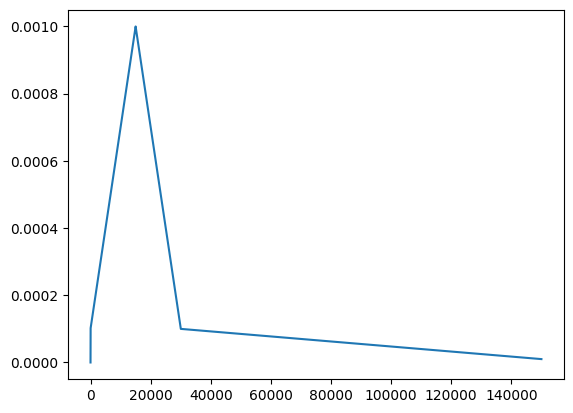

In [7]:
import matplotlib.pyplot as plt
lr[1:] = [a[0] for a in lr[1:]]
plt.plot(lr)
plt.show()